In [1]:
import sqlite3
import pandas as pd
import os
import re
import numpy as np
from sklearn import cross_validation, metrics
from sklearn.metrics import accuracy_score, roc_curve, auc,  precision_recall_curve, average_precision_score
from sklearn.grid_search import GridSearchCV
from nltk.tokenize import sent_tokenize, word_tokenize, StanfordTokenizer
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4
import string
import seaborn as sns
sns.set_style("whitegrid")
os.chdir('/Users/RayLJazz//Dropbox/UCDavis/2016spring/STA208/Github/Data')

# Read Pickles

In [2]:
SOM = pd.read_pickle('stackoverflow_metric_df.pickle')
RM = pd.read_pickle('Readability_Metrics_wtbody.pickle')
PM = pd.read_pickle('popularity_metric.pickle')

In [3]:
query = "SELECT * FROM [posts]"
conn = sqlite3.connect('crossvalidated.db')
post_df = pd.read_sql_query(query, conn)
post_df.head()
qpost_df = post_df[post_df.PostTypeId == 1]

## Stackoverflow Metrics

In [4]:
SOM.head()

,Id,ClosedDate,Score,BodyLen,LowerCasePer,UpperCasePer,SpaceCnt,TagCnt,Sentimental_Polarity,Sentimental_Subjectivity,TitleLen,UrlCnt
0,1,None,31,91,0.958763,0.041237,15,3,0.133333,0.133333,29,0
1,2,None,26,146,0.969466,0.030534,25,2,0.000000,0.000000,18,0
2,3,None,63,206,0.963303,0.036697,36,2,0.021875,0.596875,65,0
3,4,None,15,497,0.970982,0.029018,90,2,0.129808,0.552885,58,0
5,6,None,226,1628,0.962547,0.037453,204,1,-0.150000,0.300000,50,4


In [5]:
SOM.shape

(75067, 12)

In [6]:
predictors_SOM = [x for x in SOM.columns if x not in ['ClosedDate','Score']]

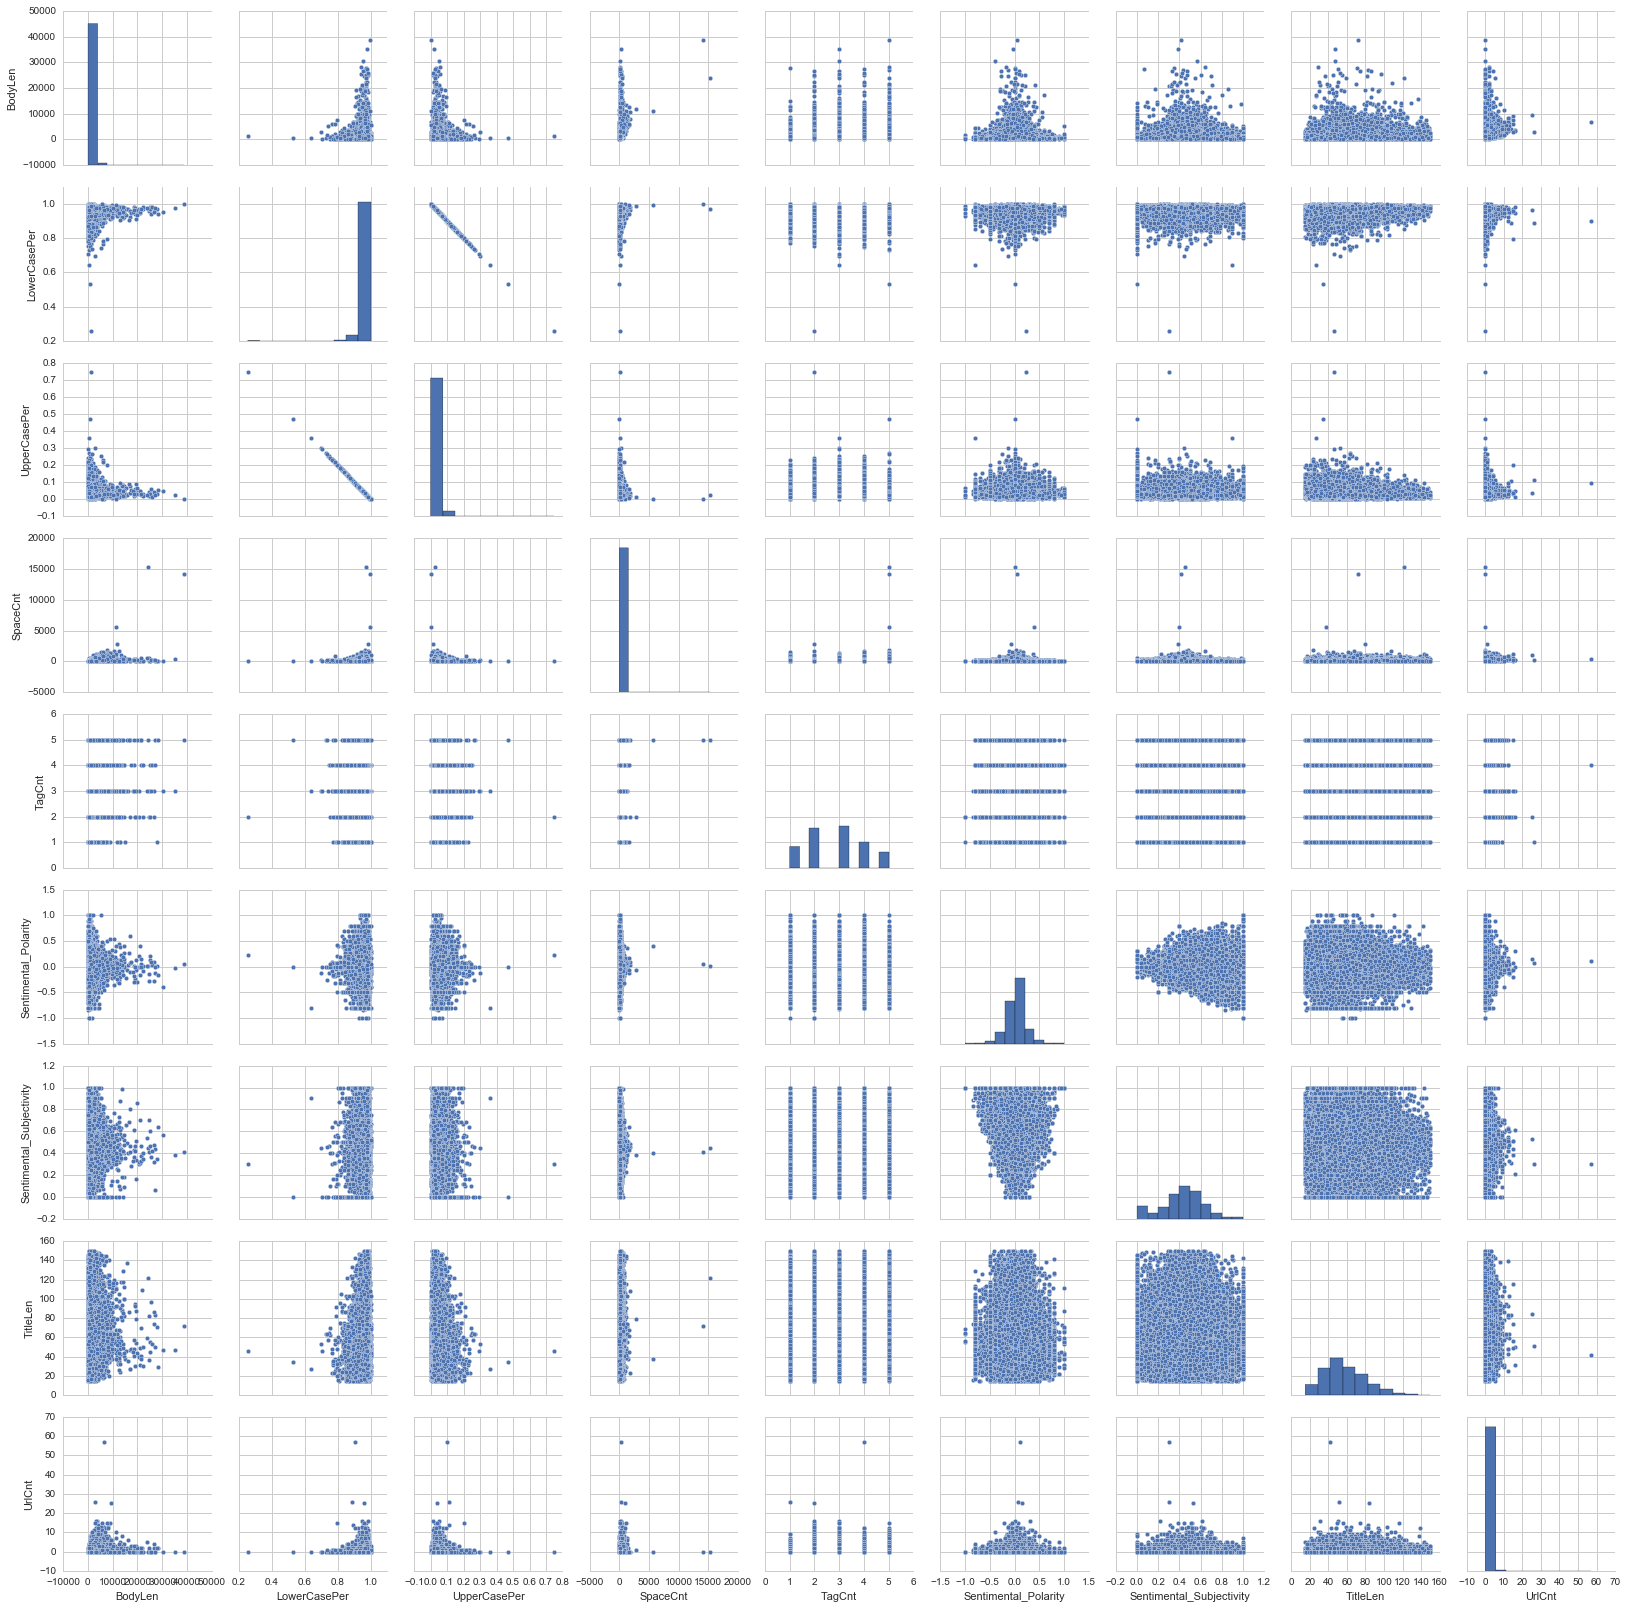

In [7]:
sns.pairplot(SOM[predictors_SOM].drop('Id',1).replace('NA', np.nan).dropna(axis=0, how='any'))

## Readability Metrics

In [8]:
RM.head()

,Id,Code number,formula,word_count,sentence_count,ARI,CLI,FKG,FRE,GFI,M_Entropy,LOC_Per,Score
0,1,0,0,13,1,10.41,13.15,9.45,50.47,23.66,0.006138,0.0,31
1,2,0,0,23,2,6.65,9.11,10.96,37,15.03,0.003698,0.0,26
2,3,0,0,29,1,18.55,14.58,18.51,14.03,19.88,0.002751,0.0,63
3,4,0,0,81,5,9.04,9.94,10.98,45.21,9.44,0.001103,0.0,15
5,6,0,0,180,7,16.76,14.27,16.27,24.23,11.62,0.000373,0.0,226


In [9]:
RM.shape

(75067, 13)

In [10]:
predictors_RM = [x for x in RM.columns if x not in ['Body','Score']]

In [11]:
RM[predictors_RM].head()

,Id,Code number,formula,word_count,sentence_count,ARI,CLI,FKG,FRE,GFI,M_Entropy,LOC_Per
0,1,0,0,13,1,10.41,13.15,9.45,50.47,23.66,0.006138,0.0
1,2,0,0,23,2,6.65,9.11,10.96,37,15.03,0.003698,0.0
2,3,0,0,29,1,18.55,14.58,18.51,14.03,19.88,0.002751,0.0
3,4,0,0,81,5,9.04,9.94,10.98,45.21,9.44,0.001103,0.0
5,6,0,0,180,7,16.76,14.27,16.27,24.23,11.62,0.000373,0.0


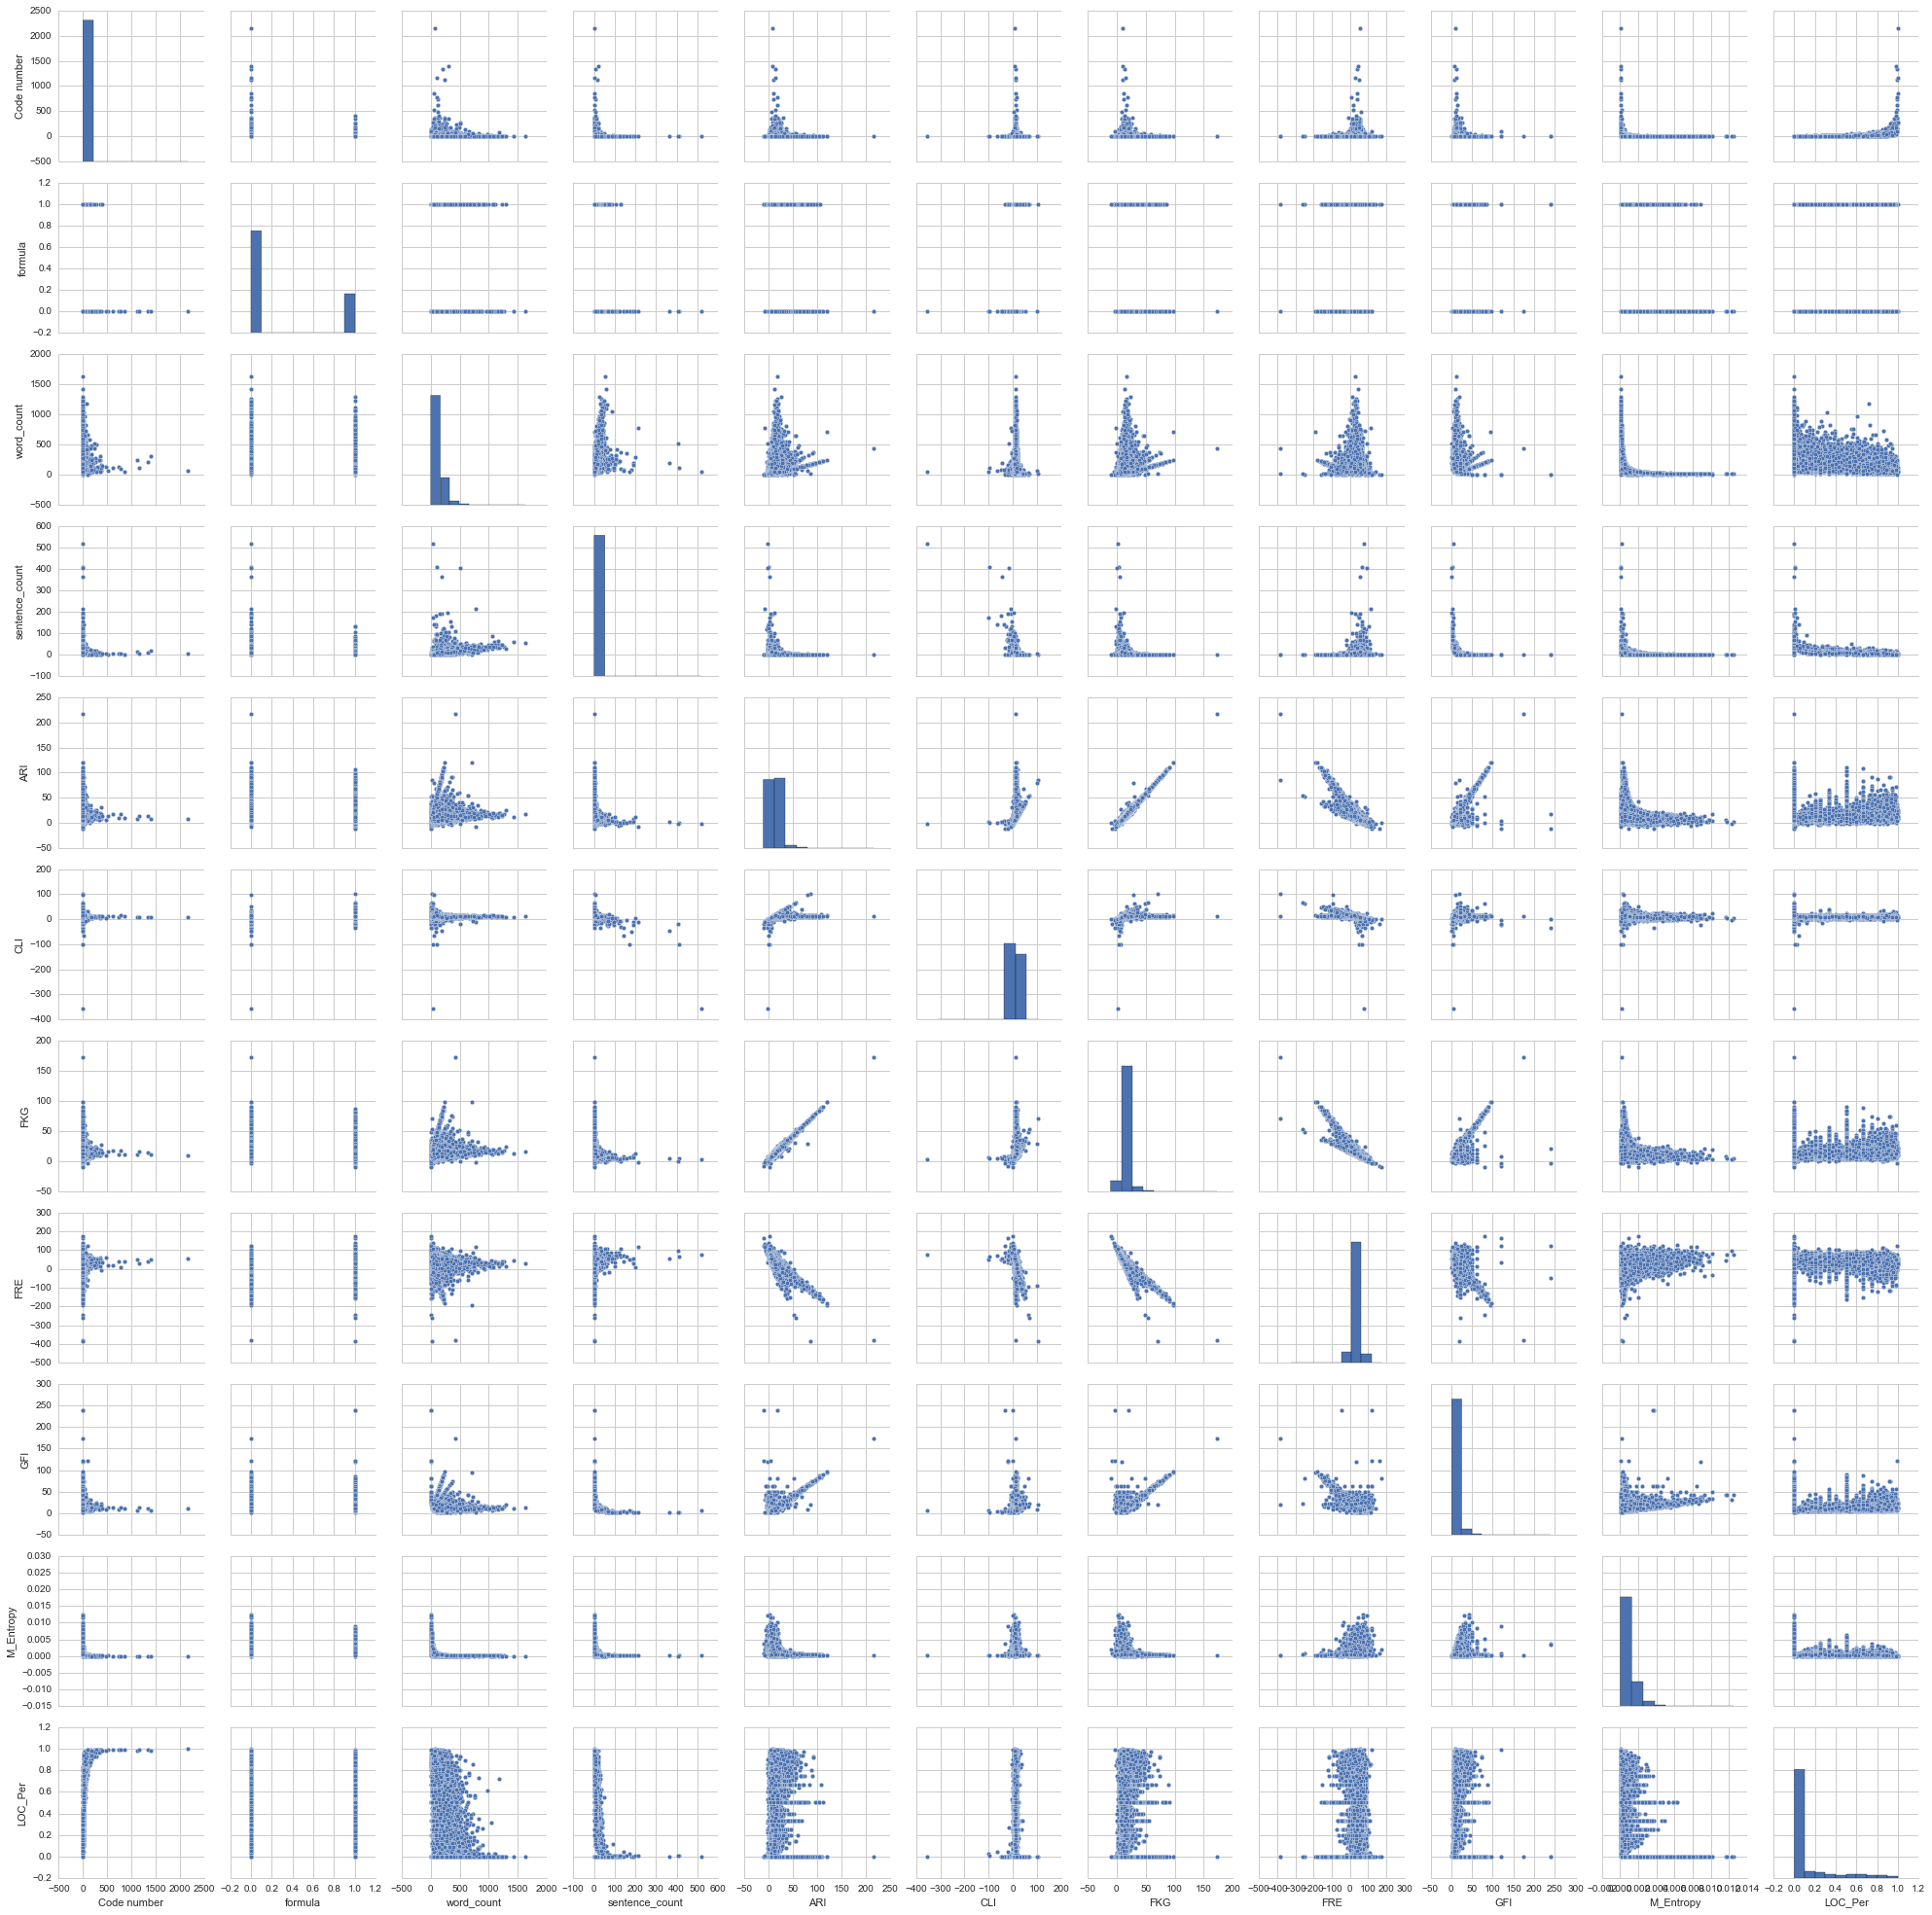

In [12]:
sns.pairplot(RM[predictors_RM].drop('Id',1).replace('NaN', np.nan).dropna(axis=0, how='any'))

## Popularity Metrics

In [13]:
PM.head()

,Id,CreationDate,OwnerUserId,AccpAnsCnt,AppEditCnt,BadgeCnt,CloDelVCnt,UpVoteCnt,DownVoteCnt,FavVoteCnt,Score
0,1,2010-07-19 19:12:12.510,8.0,0,0,0,0,0,0,0,31
1,2,2010-07-19 19:12:57.157,24.0,0,0,0,0,0,0,0,26
2,3,2010-07-19 19:13:28.577,18.0,0,0,0,0,0,0,0,63
3,4,2010-07-19 19:13:31.617,23.0,0,0,0,0,0,0,0,15
4,6,2010-07-19 19:14:44.080,5.0,0,0,0,0,0,0,0,226


In [14]:
PM.shape

(75067, 11)

In [15]:
predictors_PM = [x for x in PM.columns if x not in ['CreationDate','OwnerUserId','Score']]
target = 'Score'

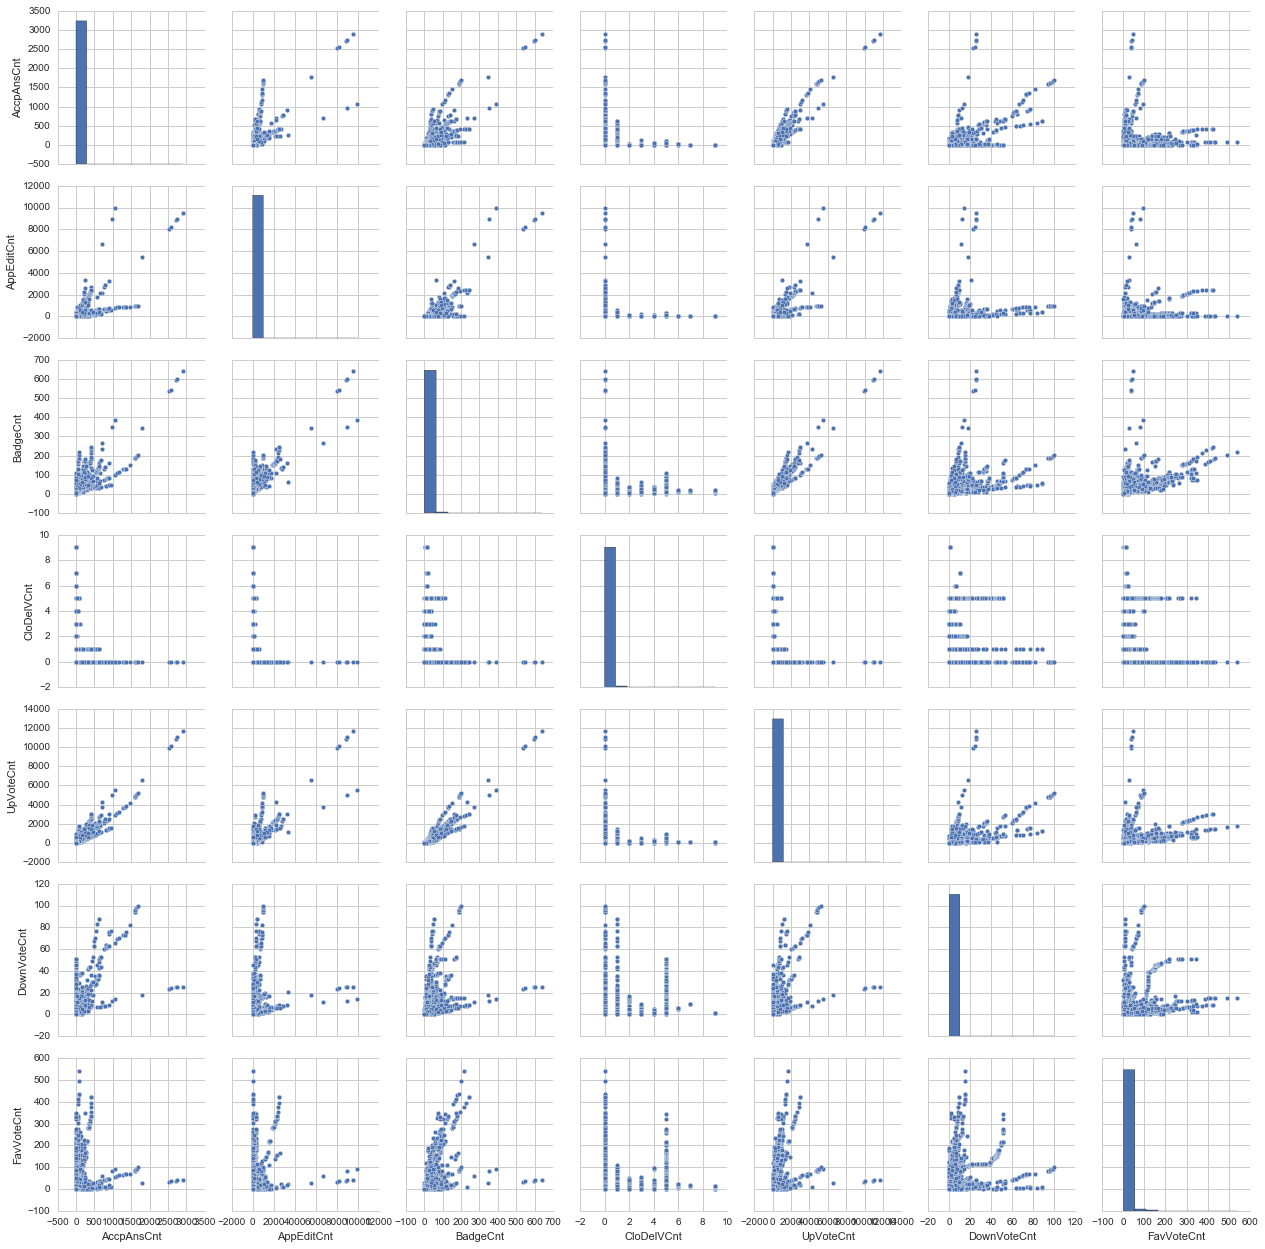

In [16]:
sns.pairplot(PM[predictors_PM].drop('Id',1))

In [17]:
dfs = [SOM[predictors_SOM],RM[predictors_RM],PM[predictors_PM],PM[['Id','Score']]]
data_SOQ = reduce(lambda left,right: pd.merge(left,right,on='Id'), dfs)

In [18]:
data_SOQ.shape, data_SOQ.columns

((75067, 29), Index([                      u'Id',                  u'BodyLen',
                    u'LowerCasePer',             u'UpperCasePer',
                        u'SpaceCnt',                   u'TagCnt',
            u'Sentimental_Polarity', u'Sentimental_Subjectivity',
                        u'TitleLen',                   u'UrlCnt',
                     u'Code number',                  u'formula',
                      u'word_count',           u'sentence_count',
                             u'ARI',                      u'CLI',
                             u'FKG',                      u'FRE',
                             u'GFI',                u'M_Entropy',
                         u'LOC_Per',               u'AccpAnsCnt',
                      u'AppEditCnt',                 u'BadgeCnt',
                      u'CloDelVCnt',                u'UpVoteCnt',
                     u'DownVoteCnt',               u'FavVoteCnt',
                           u'Score'],
       dtype='object'))

In [19]:
Class = []
def identify_class(row):
    if (row['Score']>=6) & (row['ClosedDate'] is None):
        Class.append(0)
    elif (row['Score']>=1) & (row['Score']<=5) & (row['ClosedDate']is None):
        Class.append(1)
    elif (row['Score']==0) & (row['ClosedDate']is None):
        Class.append(2)
    elif (row['Score']<0) & (row['ClosedDate']is None):
        Class.append(3)
    elif (row['ClosedDate']is not None):
        Class.append(4)

In [20]:
data_SOQ_class = qpost_df.apply(identify_class,axis=1)

In [21]:
Class_df = pd.Series(data=Class)
data_SOQ['Class'] = Class_df
data_SOQ['Class'].value_counts()

1    42336
2    21598
0     6933
4     3672
3      528
Name: Class, dtype: int64

In [22]:
Class_char = pd.Categorical.from_codes(data_SOQ['Class'], ['A','B','C','D','E'])
data_SOQ['Class_char'] = Class_char
data_SOQ=data_SOQ.replace('NA', np.nan)
data_SOQ=data_SOQ.replace('NaN', np.nan)
data_SOQ_rna = data_SOQ.dropna(axis=0, how='any')

In [23]:
data_SOQ.head(n=10)
target = 'Score'
Predictors = [x for x in data_SOQ.columns if x not in ['Id','Score','Class_char','Class','Code number']]
Predictors 

[u'BodyLen',
 u'LowerCasePer',
 u'UpperCasePer',
 u'SpaceCnt',
 u'TagCnt',
 u'Sentimental_Polarity',
 u'Sentimental_Subjectivity',
 u'TitleLen',
 u'UrlCnt',
 u'Code number',
 u'formula',
 u'word_count',
 u'sentence_count',
 u'ARI',
 u'CLI',
 u'FKG',
 u'FRE',
 u'GFI',
 u'M_Entropy',
 u'LOC_Per',
 'AccpAnsCnt',
 'AppEditCnt',
 'BadgeCnt',
 'CloDelVCnt',
 'UpVoteCnt',
 'DownVoteCnt',
 'FavVoteCnt']

In [24]:
import pickle
with open('data_SOQ_rna.pickle', 'wb') as handle:
    pickle.dump(data_SOQ_rna, handle,protocol=2)

In [25]:
data_SOQ_rna=pd.read_pickle('data_SOQ_rna.pickle')

In [35]:
data_SOQ_rna[Predictors].shape

(75059, 27)

# Modeling-- Random Forest

In [36]:
train_x, test_x, train_y, test_y = cross_validation.train_test_split(data_SOQ_rna[Predictors], data_SOQ_rna['Class'], test_size=0.3,random_state=1,stratify=data_SOQ_rna['Class'])

In [37]:
train_x.shape, test_x.shape, train_y.shape, test_y.shape

((52541, 31), (22518, 31), (52541,), (22518,))

In [38]:
train_y.value_counts(),  test_y.value_counts()

(1    29633
 2    15116
 0     4853
 4     2570
 3      369
 Name: Class, dtype: int64, 1    12700
 2     6479
 0     2080
 4     1101
 3      158
 Name: Class, dtype: int64)

In [41]:
from sklearn.ensemble import RandomForestClassifier

In [42]:
clf = RandomForestClassifier(n_estimators=1000,n_jobs=-1,random_state=1,oob_score = True)

In [43]:
param_grid = { 
    'n_estimators': range(200,1100,100)
}

CV_clf = GridSearchCV(estimator=clf, param_grid=param_grid, cv= 5)
CV_clf.fit(train_x[Predictors], train_y)
CV_clf.grid_scores_, CV_clf.best_params_, CV_clf.best_score_

([mean: 0.55987, std: 0.00142, params: {'n_estimators': 200},
  mean: 0.56032, std: 0.00282, params: {'n_estimators': 300},
  mean: 0.56086, std: 0.00317, params: {'n_estimators': 400},
  mean: 0.56107, std: 0.00281, params: {'n_estimators': 500},
  mean: 0.56107, std: 0.00329, params: {'n_estimators': 600},
  mean: 0.56145, std: 0.00321, params: {'n_estimators': 700},
  mean: 0.56189, std: 0.00308, params: {'n_estimators': 800},
  mean: 0.56131, std: 0.00327, params: {'n_estimators': 900},
  mean: 0.56141, std: 0.00325, params: {'n_estimators': 1000}],
 {'n_estimators': 800},
 0.56188500409204245)

In [44]:
clf = RandomForestClassifier(n_estimators=800,n_jobs=-1,random_state=1,oob_score = True)

In [45]:
clf.fit(train_x[Predictors], train_y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=800, n_jobs=-1,
            oob_score=True, random_state=1, verbose=0, warm_start=False)

In [46]:
clf.oob_score_, clf.feature_importances_

(0.56196113511353041,
 array([ 0.05736392,  0.05690611,  0.05693482,  0.05226002,  0.02414137,
         0.05754905,  0.05729153,  0.05853634,  0.01095638,  0.01329498,
         0.00808756,  0.05096379,  0.02274183,  0.05529747,  0.06050947,
         0.05454268,  0.05751345,  0.05313503,  0.05762664,  0.01627699,
         0.01517452,  0.01997469,  0.02680394,  0.00182418,  0.03055094,
         0.00779954,  0.01594279]))

In [47]:
preds = clf.predict(test_x[Predictors])
metrics.accuracy_score(test_y, preds),
#print('ROC: %.2f' % (metrics.roc_auc_score(test_y, preds)))

(0.56283861799449331,)

In [48]:
pd.crosstab(test_y, preds, rownames=['actual'], colnames=['preds'])

preds,0,1,2,4
actual,,,,
0,37,1986,53,4
1,27,12011,656,6
2,5,5854,617,3
3,0,140,15,3
4,3,964,125,9


In [49]:
def plot_featureimportance(model_feature):
    feature_importance = pd.DataFrame(model_feature, index = Predictors)
    feature_importance = feature_importance.sort(0,ascending=False)
    #plt.figure(figsize=(10, 8))
    feature_importance.plot(kind='barh', title='Feature Importances').invert_yaxis()
    plt.ylabel('Feature Importance Score')
    plt.show()

/Users/RayLJazz/miniconda3/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:3: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  app.launch_new_instance()


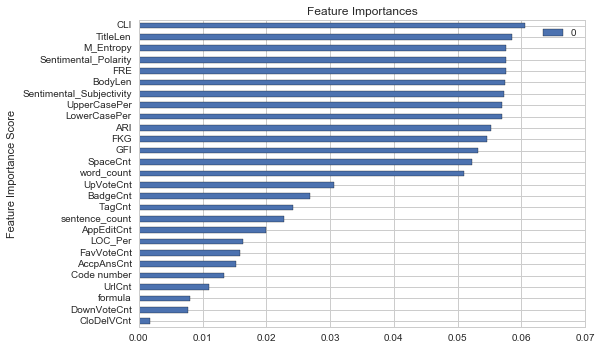

In [50]:
plot_featureimportance(clf.feature_importances_)

## Extreme Gradient Boosting

### Step 1- Find the number of estimators for a high learning rate

In [51]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

In [52]:
train = train_x
train['Score'] = train_y
test = test_x
test['Score'] = test_y

/Users/RayLJazz/miniconda3/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/RayLJazz/miniconda3/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [53]:
train.shape, test.shape

((52541, 31), (22518, 31))

In [54]:
def modelfit(alg, dtrain, dtest, predictors,target, useTrainCV=True, cv_folds=5, early_stopping_round=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values,missing=np.nan)
        xgtest = xgb.DMatrix(dtest[predictors].values,missing=np.nan)
        xgb_param_forcv = xgb_param
        xgb_param_forcv['num_class'] = 5
        cvresult = xgb.cv(xgb_param_forcv, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
             early_stopping_rounds=early_stopping_round, show_progress=True)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain[target],eval_metric='merror')
    
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    #dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
    return alg, dtrain_predictions
   

In [55]:
xgb1 = XGBClassifier(
        learning_rate =0.1,
        n_estimators=1000,
        max_depth=5,
        min_child_weight=1,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        objective= 'multi:softmax',
        nthread=4,
        scale_pos_weight=1,
        seed=27)
xgb1, dtrain_predictions = modelfit(xgb1, train, test, Predictors,target)

Will train until cv error hasn't decreased in 50 rounds.
[0]	cv-test-merror:0.4376094+0.00627482910046	cv-train-merror:0.43278+0.00164211960588
[1]	cv-test-merror:0.4360678+0.00647938705126	cv-train-merror:0.4327608+0.00157510360294
[2]	cv-test-merror:0.4356682+0.00643263971943	cv-train-merror:0.4330558+0.00161192039506
[3]	cv-test-merror:0.4355918+0.00613759618743	cv-train-merror:0.4333556+0.00157888373226
[4]	cv-test-merror:0.435573+0.00624610915691	cv-train-merror:0.433265+0.00162380577656
[5]	cv-test-merror:0.435611+0.00623875256762	cv-train-merror:0.4332938+0.00169047264397
[6]	cv-test-merror:0.4354208+0.00626547566909	cv-train-merror:0.4330414+0.00178548700359
[7]	cv-test-merror:0.4354016+0.00631556349347	cv-train-merror:0.4330036+0.00186583660592
[8]	cv-test-merror:0.435173+0.00641865649494	cv-train-merror:0.4327942+0.0017524265919
[9]	cv-test-merror:0.435078+0.0067391807514	cv-train-merror:0.432499+0.00180615204233
[10]	cv-test-merror:0.4349258+0.00658974644125	cv-train-merror:

In [56]:
def get_performance(xgbmodel,dtrain,dtest,predictors,dtrain_predictions):
    print "\nModel Report"
    print "Train accuracy : %.4g" % metrics.accuracy_score(dtrain[target].values, dtrain_predictions)
    test_result = xgbmodel.predict(dtest[predictors])
    print "Test accuracy : %.4g" % metrics.accuracy_score(dtest[target].values, test_result)
    print pd.crosstab(dtest[target].values, test_result, rownames=['actual'], colnames=['preds'])
    feat_imp = pd.Series(xgbmodel.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='barh', title='Feature Importances').invert_yaxis()
    plt.ylabel('Feature Importance Score')


Model Report
Train accuracy : 0.588
Test accuracy : 0.5675
preds    0      1    2  4
actual                   
0       48   2000   31  1
1       32  12300  362  6
2        1   6052  423  3
3        0    150    8  0
4        2    999   92  8


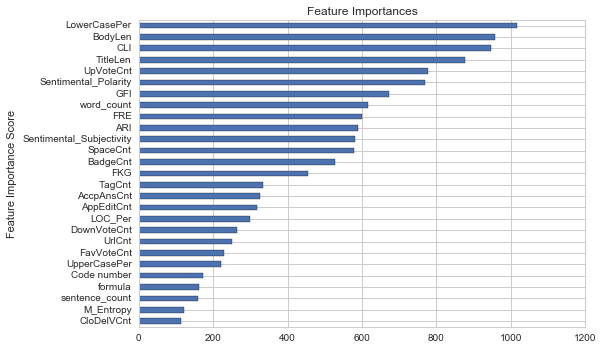

In [57]:
get_performance(xgb1,train,test,Predictors,dtrain_predictions)

### Hyperparameter Tuning
### Step 2: Tune max_depth and min_child_weight

In [58]:
param_test1 = {
 'max_depth':range(3,10,1),
 'min_child_weight':range(1,6,1)
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=97, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'multi:softprob', nthread=4, scale_pos_weight=1, seed=27,reg_alpha=0, reg_lambda=1), 
 param_grid = param_test1, scoring='accuracy',n_jobs=4,iid=False, cv=5)
gsearch1.fit(train[Predictors],train[target])
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

([mean: 0.56702, std: 0.00094, params: {'max_depth': 3, 'min_child_weight': 1},
  mean: 0.56662, std: 0.00081, params: {'max_depth': 3, 'min_child_weight': 2},
  mean: 0.56699, std: 0.00083, params: {'max_depth': 3, 'min_child_weight': 3},
  mean: 0.56653, std: 0.00092, params: {'max_depth': 3, 'min_child_weight': 4},
  mean: 0.56710, std: 0.00076, params: {'max_depth': 3, 'min_child_weight': 5},
  mean: 0.56697, std: 0.00091, params: {'max_depth': 4, 'min_child_weight': 1},
  mean: 0.56720, std: 0.00088, params: {'max_depth': 4, 'min_child_weight': 2},
  mean: 0.56739, std: 0.00070, params: {'max_depth': 4, 'min_child_weight': 3},
  mean: 0.56687, std: 0.00121, params: {'max_depth': 4, 'min_child_weight': 4},
  mean: 0.56721, std: 0.00125, params: {'max_depth': 4, 'min_child_weight': 5},
  mean: 0.56693, std: 0.00105, params: {'max_depth': 5, 'min_child_weight': 1},
  mean: 0.56697, std: 0.00172, params: {'max_depth': 5, 'min_child_weight': 2},
  mean: 0.56687, std: 0.00136, params: {

In [61]:
xgb2 = XGBClassifier(
        learning_rate =0.1,
        n_estimators=1000,
        max_depth=4,
        min_child_weight=3,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        objective= 'multi:softmax',
        nthread=4,
        scale_pos_weight=1,
        seed=27)
xgb2, dtrain_predictions = modelfit(xgb2, train, test, Predictors,target)

Will train until cv error hasn't decreased in 50 rounds.
[0]	cv-test-merror:0.4368104+0.00594767512899	cv-train-merror:0.4348686+0.00155707387108
[1]	cv-test-merror:0.4360104+0.00576511302925	cv-train-merror:0.4351778+0.001676700498
[2]	cv-test-merror:0.4358774+0.00607085696092	cv-train-merror:0.4354112+0.00154738093565
[3]	cv-test-merror:0.4357442+0.00624643256267	cv-train-merror:0.4353826+0.00154678926813
[4]	cv-test-merror:0.4357634+0.00626304455038	cv-train-merror:0.43534+0.00160392979896
[5]	cv-test-merror:0.4359724+0.00599129467144	cv-train-merror:0.4355348+0.0016260781531
[6]	cv-test-merror:0.4359728+0.00615455647143	cv-train-merror:0.4355016+0.00161262030249
[7]	cv-test-merror:0.4358014+0.00601646499533	cv-train-merror:0.4354492+0.00165486318468
[8]	cv-test-merror:0.4359536+0.0061039901245	cv-train-merror:0.435349+0.00168636627101
[9]	cv-test-merror:0.4357824+0.00620319139153	cv-train-merror:0.4352112+0.00159235968299
[10]	cv-test-merror:0.4359154+0.00612224947548	cv-train-merr


Model Report
Train accuracy : 0.5834
Test accuracy : 0.5677
preds    0      1    2  3  4
actual                      
0       38   2010   31  0  1
1       39  12290  368  1  2
2        2   6023  451  0  3
3        0    147   11  0  0
4        3    987  106  0  5


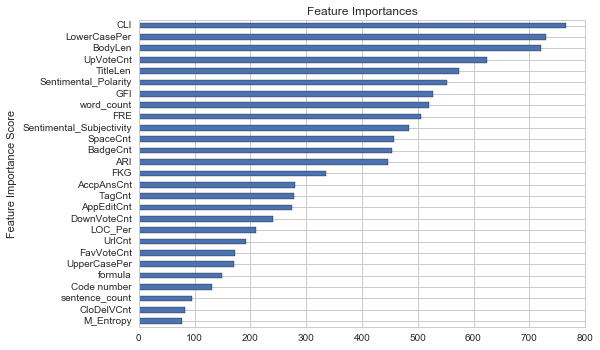

In [63]:
get_performance(xgb2,train,test,Predictors,dtrain_predictions)

## Step 3: Tune gamma

In [64]:
xgb2

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=4,
       min_child_weight=3, missing=None, n_estimators=151, nthread=4,
       objective='multi:softprob', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=27, silent=True, subsample=0.8)

In [65]:
param_test2 = {
 'gamma':[i/10.0 for i in range(0,6)]
}
gsearch2 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=151, max_depth=4,
 min_child_weight=3, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'multi:softprob', nthread=4, scale_pos_weight=1, seed=27,reg_alpha=0, reg_lambda=1), 
 param_grid = param_test2, scoring='accuracy',n_jobs=4,iid=False, cv=5)
gsearch2.fit(train[Predictors],train[target])
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

([mean: 0.56754, std: 0.00187, params: {'gamma': 0.0},
  mean: 0.56721, std: 0.00101, params: {'gamma': 0.1},
  mean: 0.56731, std: 0.00181, params: {'gamma': 0.2},
  mean: 0.56739, std: 0.00147, params: {'gamma': 0.3},
  mean: 0.56721, std: 0.00184, params: {'gamma': 0.4},
  mean: 0.56735, std: 0.00149, params: {'gamma': 0.5}],
 {'gamma': 0.0},
 0.56753771963503874)

## Step 4: Tune subsample and colsample_bytree

In [66]:
param_test3 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=151, max_depth=4,
 min_child_weight=3, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'multi:softprob', nthread=4, scale_pos_weight=1, seed=27,reg_alpha=0, reg_lambda=1), 
 param_grid = param_test3, scoring='accuracy',n_jobs=4,iid=False, cv=5)
gsearch3.fit(train[Predictors],train[target])
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

([mean: 0.56653, std: 0.00119, params: {'subsample': 0.6, 'colsample_bytree': 0.6},
  mean: 0.56594, std: 0.00132, params: {'subsample': 0.7, 'colsample_bytree': 0.6},
  mean: 0.56706, std: 0.00128, params: {'subsample': 0.8, 'colsample_bytree': 0.6},
  mean: 0.56681, std: 0.00102, params: {'subsample': 0.9, 'colsample_bytree': 0.6},
  mean: 0.56695, std: 0.00166, params: {'subsample': 0.6, 'colsample_bytree': 0.7},
  mean: 0.56638, std: 0.00109, params: {'subsample': 0.7, 'colsample_bytree': 0.7},
  mean: 0.56647, std: 0.00138, params: {'subsample': 0.8, 'colsample_bytree': 0.7},
  mean: 0.56689, std: 0.00160, params: {'subsample': 0.9, 'colsample_bytree': 0.7},
  mean: 0.56756, std: 0.00077, params: {'subsample': 0.6, 'colsample_bytree': 0.8},
  mean: 0.56655, std: 0.00033, params: {'subsample': 0.7, 'colsample_bytree': 0.8},
  mean: 0.56754, std: 0.00187, params: {'subsample': 0.8, 'colsample_bytree': 0.8},
  mean: 0.56685, std: 0.00089, params: {'subsample': 0.9, 'colsample_bytree'

In [67]:
xgb3 = XGBClassifier(
        learning_rate =0.1,
        n_estimators=1000,
        max_depth=4,
        min_child_weight=3,
        gamma=0,
        subsample=0.6,
        colsample_bytree=0.8,
        objective= 'multi:softmax',
        nthread=4,
        scale_pos_weight=1,
        seed=27)
xgb3, dtrain_predictions = modelfit(xgb3, train, test, Predictors,target)

Will train until cv error hasn't decreased in 50 rounds.
[0]	cv-test-merror:0.43681+0.00593230211638	cv-train-merror:0.4348638+0.00159503936002
[1]	cv-test-merror:0.436068+0.00605431736862	cv-train-merror:0.4348686+0.00168252305779
[2]	cv-test-merror:0.4357442+0.00626733402333	cv-train-merror:0.4351066+0.00142055040037
[3]	cv-test-merror:0.4357632+0.00619556132727	cv-train-merror:0.435316+0.00149927115626
[4]	cv-test-merror:0.4357632+0.00615594137074	cv-train-merror:0.4352828+0.0015432280972
[5]	cv-test-merror:0.4358774+0.00608212589807	cv-train-merror:0.4352922+0.00159020116966
[6]	cv-test-merror:0.4359154+0.00591860032778	cv-train-merror:0.4352732+0.00164520605396
[7]	cv-test-merror:0.4360678+0.0059956874635	cv-train-merror:0.435254+0.00169115463515
[8]	cv-test-merror:0.4361248+0.00608456330068	cv-train-merror:0.4352304+0.00160508923116
[9]	cv-test-merror:0.4361248+0.0059996080672	cv-train-merror:0.4351254+0.00156475846059
[10]	cv-test-merror:0.4359346+0.0058233892743	cv-train-merror


Model Report
Train accuracy : 0.5751
Test accuracy : 0.5679
preds    0      1    2  4
actual                   
0       26   2038   16  0
1       25  12458  214  3
2        0   6177  301  1
3        0    150    8  0
4        2   1019   77  3


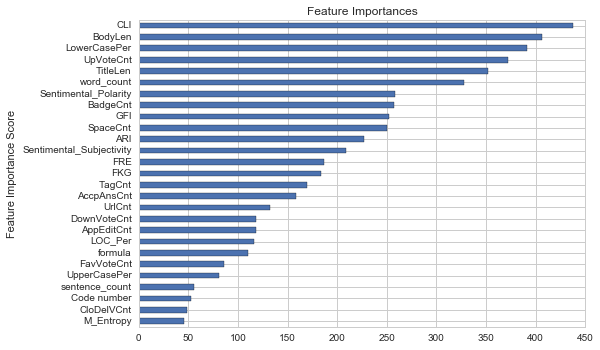

In [69]:
get_performance(xgb3,train,test,Predictors,dtrain_predictions)

## Step 5: Tuning Regularization Parameters

In [70]:
param_test4 = {
 'reg_alpha':[0, 0.001, 0.005, 0.01, 0.05]
}
gsearch4 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=80, max_depth=4,
 min_child_weight=3, gamma=0, subsample=0.6, colsample_bytree=0.8,
 objective= 'multi:softprob', nthread=4, scale_pos_weight=1, seed=27,reg_alpha=0, reg_lambda=1), 
 param_grid = param_test4, scoring='accuracy',n_jobs=4,iid=False, cv=5)
gsearch4.fit(train[Predictors],train[target])
gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

([mean: 0.56702, std: 0.00073, params: {'reg_alpha': 0},
  mean: 0.56685, std: 0.00060, params: {'reg_alpha': 0.001},
  mean: 0.56727, std: 0.00096, params: {'reg_alpha': 0.005},
  mean: 0.56716, std: 0.00098, params: {'reg_alpha': 0.01},
  mean: 0.56699, std: 0.00086, params: {'reg_alpha': 0.05}],
 {'reg_alpha': 0.005},
 0.56727137189963561)

In [72]:
xgb4 = XGBClassifier(
        learning_rate =0.1,
        n_estimators=1000,
        max_depth=4,
        min_child_weight=3,
        gamma=0,
        subsample=0.6,
        colsample_bytree=0.8,
        objective= 'multi:softmax',
        nthread=4,
        scale_pos_weight=1,
        reg_alpha=0.005,
        seed=27)
xgb4, dtrain_predictions = modelfit(xgb4, train, test, Predictors,target)

Will train until cv error hasn't decreased in 50 rounds.
[0]	cv-test-merror:0.43681+0.00593230211638	cv-train-merror:0.4348638+0.00159503936002
[1]	cv-test-merror:0.436068+0.00605431736862	cv-train-merror:0.4348686+0.00168252305779
[2]	cv-test-merror:0.4357442+0.00626733402333	cv-train-merror:0.4351066+0.00142055040037
[3]	cv-test-merror:0.4357632+0.00619556132727	cv-train-merror:0.435316+0.00149927115626
[4]	cv-test-merror:0.4357822+0.00616222464375	cv-train-merror:0.4352828+0.0015432280972
[5]	cv-test-merror:0.4358774+0.00608212589807	cv-train-merror:0.4352922+0.00159020116966
[6]	cv-test-merror:0.4359154+0.00591860032778	cv-train-merror:0.4352732+0.00164520605396
[7]	cv-test-merror:0.4360678+0.0059956874635	cv-train-merror:0.435254+0.00169115463515
[8]	cv-test-merror:0.4361248+0.00608456330068	cv-train-merror:0.4352304+0.00160508923116
[9]	cv-test-merror:0.4361248+0.0059996080672	cv-train-merror:0.4351254+0.00156475846059
[10]	cv-test-merror:0.4359346+0.0058233892743	cv-train-merror


Model Report
Train accuracy : 0.575
Test accuracy : 0.5676
preds    0      1    2  4
actual                   
0       33   2030   17  0
1       27  12431  239  3
2        0   6163  316  0
3        0    149    9  0
4        1   1021   77  2


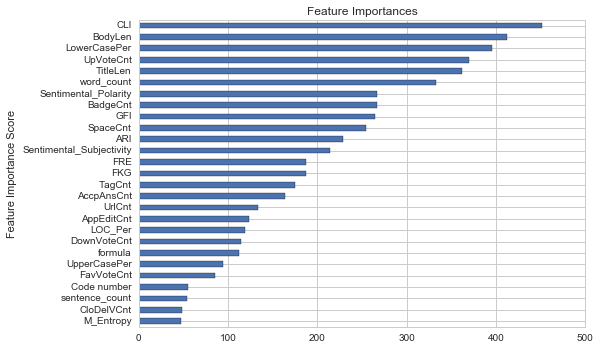

In [73]:
get_performance(xgb4,train,test,Predictors,dtrain_predictions)